#### This is a subset of the allen ai dataset, entries with irregular titles are removed

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import functools
from sklearn.feature_extraction.text import TfidfVectorizer

plt.style.use('ggplot')
%matplotlib inline

In [2]:
ALLEN_AI_SUBS_PATH = "../res/allenai/metadata_subset.csv"

In [3]:
df_allen = pd.read_csv(ALLEN_AI_SUBS_PATH)[['source_x', 'title', 'abstract', 'publish_time', 'journal', 'is_pr']]
df_allen = df_allen.fillna('')

print(len(df_allen.index))
df_allen.head(5)

58007


,source_x,title,abstract,publish_time,journal,is_pr
0,PMC,Sequence requirements for RNA strand transfer ...,Nidovirus subgenomic mRNAs contain a leader se...,2001-12-17,The EMBO Journal,True
1,PMC,"Crystal structure of murine sCEACAM1a[1,4]: a ...",CEACAM1 is a member of the carcinoembryonic an...,2002-05-01,The EMBO Journal,True
2,PMC,Synthesis of a novel hepatitis C virus protein...,Hepatitis C virus (HCV) is an important human ...,2001-07-16,EMBO J,True
3,PMC,Structure of coronavirus main proteinase revea...,The key enzyme in coronavirus polyprotein proc...,2002-07-01,The EMBO Journal,True
4,PMC,Discontinuous and non-discontinuous subgenomic...,"Arteri-, corona-, toro- and roniviruses are ev...",2002-12-01,The EMBO Journal,True


In [4]:
def get_tfidf_vec(sr_str):
    tfidf = TfidfVectorizer(stop_words='english', min_df=.001, max_df=0.5)
    tfidf_data = tfidf.fit_transform(sr_str.values)
    return tfidf_data, tfidf

def get_avg_importance(tfidf_data, tfidf_vec):
    sum_counts = functools.reduce(lambda a,b: a+b, tfidf_data)
    word_freq = zip(tfidf_vec.get_feature_names(), sum_counts.A[0]/tfidf_data.shape[0])
    word_freq = sorted(word_freq, key=lambda x:x[1], reverse=True)
    df_imp = pd.DataFrame(word_freq, columns=['term', 'relevance']).set_index('term')
    return df_imp

## Title based tf-idf

In [5]:
td, tfidf = get_tfidf_vec(df_allen.title)

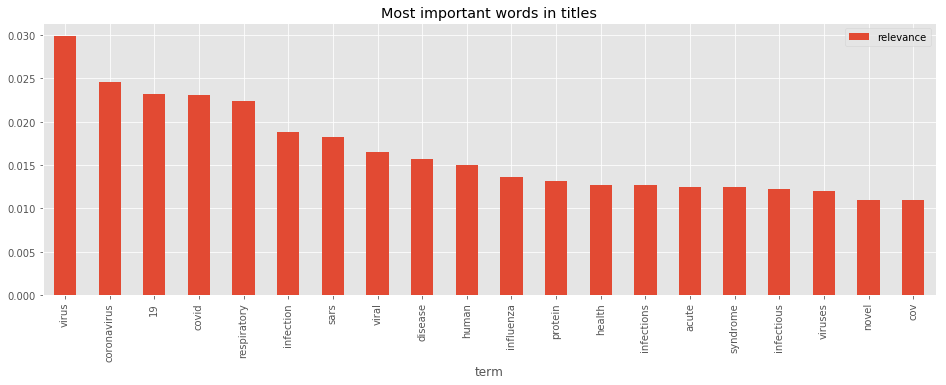

In [6]:
df_general = get_avg_importance(td,tfidf)
df_general.iloc[:20,].plot(kind='bar', title='Most important words in titles', figsize=(16,5))

In [7]:
unique_sources = df_allen.source_x.unique()
df_list = []
for i, source in enumerate(unique_sources):
    tfidf_data = td.tocsr()[np.where(df_allen.source_x==source)[0],:]
    df_res = get_avg_importance(tfidf_data, tfidf)
    df_res['source'] = source
    df_list.append(df_res)

df_ti_source = pd.concat(df_list)
df_ti_source.head(5)

,relevance,source
term,,
virus,0.035423,PMC
respiratory,0.025928,PMC
coronavirus,0.022727,PMC
infection,0.020492,PMC
human,0.018723,PMC


In [8]:
df_ti_rel = df_ti_source.set_index('source', append=True)
most_rel_terms = df_ti_source.groupby('term').max().nlargest(10, 'relevance').index.values
most_rel_terms

array(['19', 'covid', 'coronavirus', '2019', 'novel', 'ncov', 'cov',
       'sars', 'pneumonia', 'wuhan'], dtype=object)

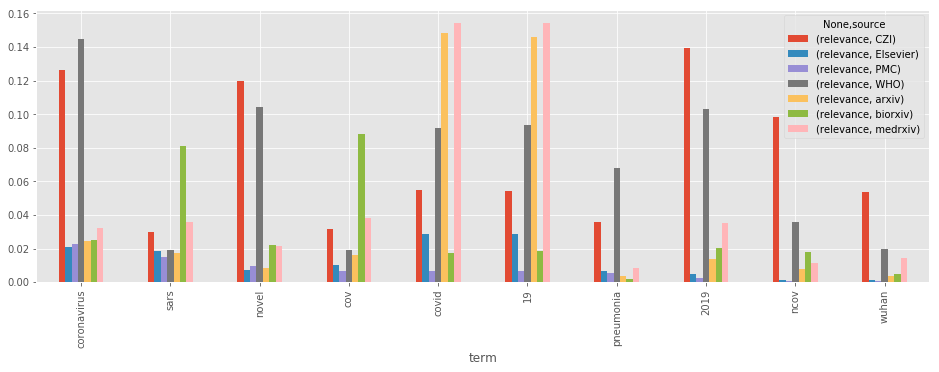

In [9]:
df_ti_rel[df_ti_rel.index.get_level_values(0).isin(most_rel_terms)].unstack().plot(kind='bar', figsize=(16,5))

In [10]:
df_list = []
for i, val in enumerate([True, False]):
    tfidf_data = td.tocsr()[np.where(df_allen.is_pr == val)[0],:]
    df_res = get_avg_importance(tfidf_data, tfidf)
    df_res['peer_reviewed'] = ('' if val else 'non-') + 'peer-reviewed'
    df_list.append(df_res)

df_ti_pr = pd.concat(df_list)
df_ti_pr.head(5)

,relevance,peer_reviewed
term,,
virus,0.031312,peer-reviewed
coronavirus,0.024261,peer-reviewed
respiratory,0.023618,peer-reviewed
infection,0.019132,peer-reviewed
viral,0.017189,peer-reviewed


In [11]:
df_ti_pr_rel = df_ti_pr.set_index('peer_reviewed', append=True)
most_rel_pr_terms = df_ti_pr.groupby('term').max().nlargest(10, 'relevance').index.values
most_rel_pr_terms

array(['covid', '19', 'cov', 'sars', 'virus', 'coronavirus', '2019',
       'model', 'epidemic', 'respiratory'], dtype=object)

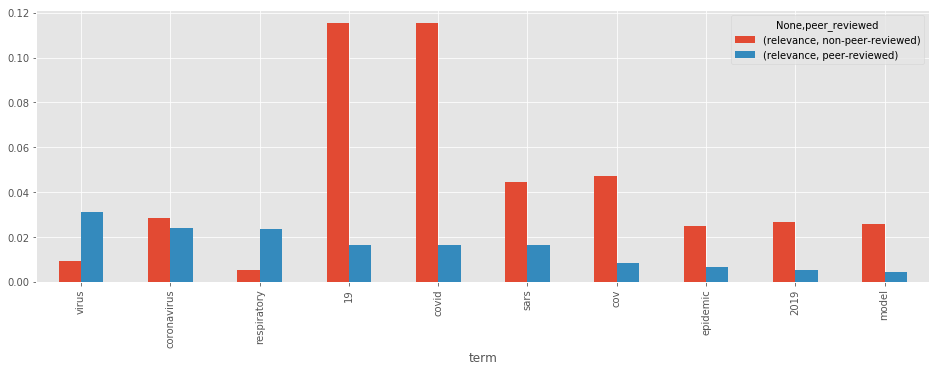

In [12]:
df_ti_pr_rel[df_ti_pr_rel.index.get_level_values(0).isin(most_rel_pr_terms)].unstack().plot(kind='bar', figsize=(16,5))

In [13]:
df_rel_dif = df_ti_pr_rel.reset_index().pivot(index='term',columns='peer_reviewed', values='relevance')
df_rel_dif['diff'] = df_rel_dif['non-peer-reviewed'] - df_rel_dif['peer-reviewed']
df_rel_dif['absdiff'] = np.abs(df_rel_dif['diff'])
df_rel_dif.sort_values(by='absdiff', ascending=False, inplace=True)
df_rel_dif.head(20)

peer_reviewed,non-peer-reviewed,peer-reviewed,diff,absdiff
term,,,,
covid,0.115223,0.016539,0.098684,0.098684
19,0.115185,0.016669,0.098516,0.098516
cov,0.047385,0.008332,0.039053,0.039053
sars,0.044380,0.016397,0.027983,0.027983
virus,0.009427,0.031312,-0.021884,0.021884
model,0.025880,0.004581,0.021298,0.021298
2019,0.026684,0.005608,0.021076,0.021076
epidemic,0.024950,0.006668,0.018282,0.018282
respiratory,0.005403,0.023618,-0.018214,0.018214


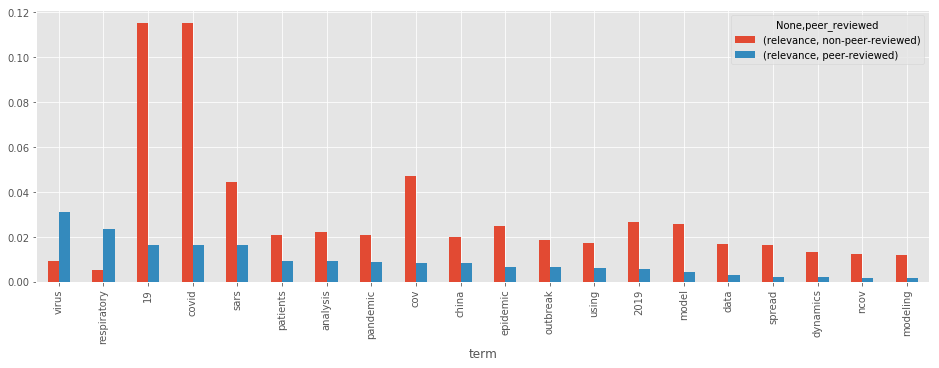

In [ ]:
#excluded_list = ['virus', 'coronavirus', 'cov', '19','covid', '2019']
excluded_list = []
col_of_interest = [x for x in df_rel_dif.index[:20+len(excluded_list)] if x not in excluded_list]
df_ti_pr_rel[df_ti_pr_rel.index.get_level_values(0).isin(col_of_interest)].unstack().plot(kind='bar', figsize=(16,5))

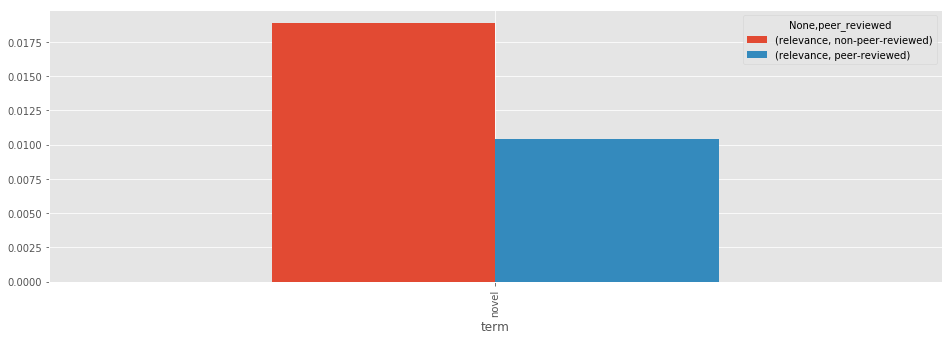

In [ ]:
col_of_interest = ['novel', 'unprecedented', 'excellent', 'remarkable', 'exciting', 'brilliant']
df_ti_pr_rel[df_ti_pr_rel.index.get_level_values(0).isin(col_of_interest)].unstack().plot(kind='bar', figsize=(16,5))

#### Records which should be possibly removed

In [ ]:
df_allen[df_allen.title.str.contains('index') | df_allen.title.str.contains('chapter')]

,source_x,title,abstract,publish_time,journal,is_pr
1545,PMC,A rebuttal to the comments on the genome order...,"BACKGROUND: Elhaik, Graur and Josic recently c...",2011-02-16,Biol Direct,True
1773,PMC,Prediction of outcome and prognosis of patient...,"CONTEXT: Body mass index (BMI), serum albumin,...",2011,Indian J Crit Care Med,True
3051,PMC,Publications in ISI-indexed public health jour...,BACKGROUND: There has been a steady increase i...,2011-07-01,Med Sci Monit,True
7276,PMC,Introduction of neutralizing immunogenicity in...,Viral subunit vaccines often contain immunodom...,2016-11-22,Nat Commun,True
9774,PMC,The utility of delta neutrophil index in diffe...,No data exist on the usefulness of the delta n...,2018-08-17,Sci Rep,True
10725,PMC,Pneumonia severity index in viral community ac...,Pneumonia severity index (PSI) is an important...,2019-03-06,PLoS One,True
18422,PMC,Use of albumin quotient and IgG index to diffe...,Background: Inflammation of the central nervou...,2008-06-02,Vet Clin Pathol,True
18589,PMC,Respiratory virus infection after allogeneic h...,BACKGROUND: Respiratory virus infection (RVI) ...,2017-04-27,Transpl Infect Dis,True
20194,PMC,Clinical significance of dynamic monitoring of...,The aim of the present study was to analyze th...,2015-09-23,Experimental and Therapeutic Medicine,True
20837,PMC,Outbreak of severe acute respiratory syndrome ...,Objective To describe an outbreak of severe ac...,2004-01-24,BMJ,True


## Abstract based tf-idf

In [ ]:
td, tfidf = get_tfidf_vec(df_allen.abstract)

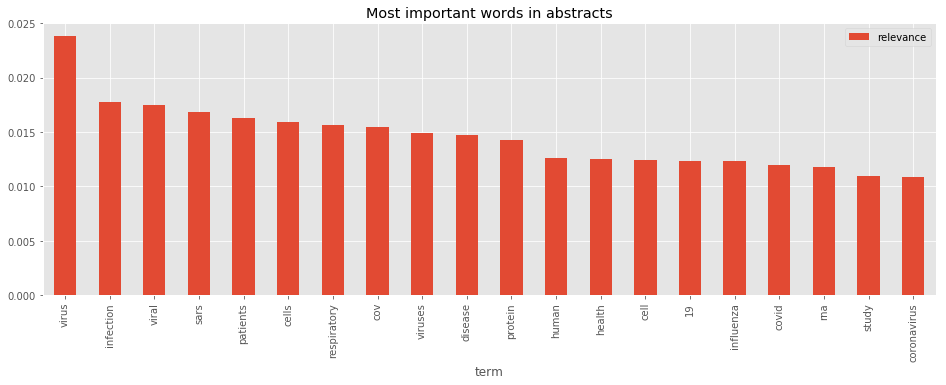

In [ ]:
df_general = get_avg_importance(td,tfidf)
df_general.iloc[:20,].plot(kind='bar', title='Most important words in abstracts', figsize=(16,5))

In [ ]:
unique_sources = df_allen.source_x.unique()
df_list = []
for i, source in enumerate(unique_sources):
    tfidf_data = td.tocsr()[np.where(df_allen.source_x==source)[0],:]
    df_res = get_avg_importance(tfidf_data, tfidf)
    df_res['source'] = source
    df_list.append(df_res)

df_ti_source = pd.concat(df_list)
df_ti_source.head(5)

,relevance,source
term,,
virus,0.028168,PMC
viral,0.020519,PMC
infection,0.020297,PMC
cells,0.019867,PMC
viruses,0.017799,PMC


In [ ]:
df_ti_rel = df_ti_source.set_index('source', append=True)
most_rel_terms = df_ti_source.groupby('term').max().nlargest(10, 'relevance').index.values
most_rel_terms

array(['covid', '19', 'cov', 'sars', '2019', 'model', 'ncov', 'patients',
       'cases', 'china'], dtype=object)

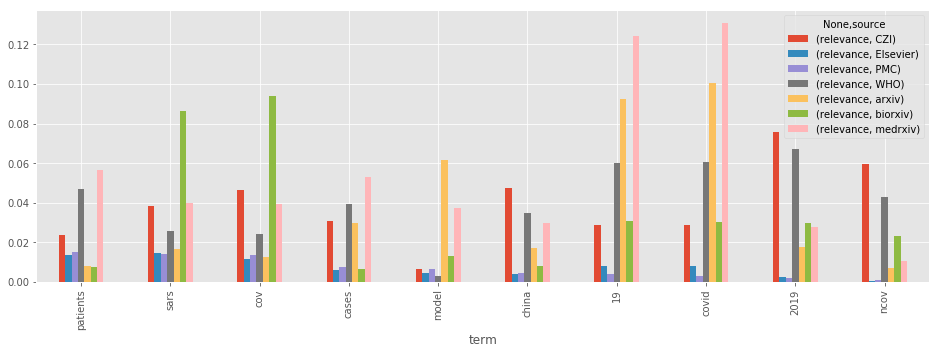

In [ ]:
df_ti_rel[df_ti_rel.index.get_level_values(0).isin(most_rel_terms)].unstack().plot(kind='bar', figsize=(16,5))

In [ ]:
df_list = []
for i, val in enumerate([True, False]):
    tfidf_data = td.tocsr()[np.where(df_allen.is_pr == val)[0],:]
    df_res = get_avg_importance(tfidf_data, tfidf)
    df_res['peer_reviewed'] = ('' if val else 'non-') + 'peer-reviewed'
    df_list.append(df_res)

df_ti_pr = pd.concat(df_list)
df_ti_pr.head(5)

,relevance,peer_reviewed
term,,
virus,0.024365,peer-reviewed
viral,0.017788,peer-reviewed
infection,0.017701,peer-reviewed
cells,0.016432,peer-reviewed
respiratory,0.016061,peer-reviewed


In [ ]:
df_ti_pr_rel = df_ti_pr.set_index('peer_reviewed', append=True)
most_rel_pr_terms = df_ti_pr.groupby('term').max().nlargest(10, 'relevance').index.values
most_rel_pr_terms

In [ ]:
df_ti_pr_rel[df_ti_pr_rel.index.get_level_values(0).isin(most_rel_pr_terms)].unstack().plot(kind='bar', figsize=(16,5))

In [ ]:
df_rel_dif = df_ti_pr_rel.reset_index().pivot(index='term',columns='peer_reviewed', values='relevance')
df_rel_dif['diff'] = df_rel_dif['non-peer-reviewed'] - df_rel_dif['peer-reviewed']
df_rel_dif['absdiff'] = np.abs(df_rel_dif['diff'])
df_rel_dif.sort_values(by='absdiff', ascending=False, inplace=True)
df_rel_dif.head(20)

In [ ]:
#excluded_list = ['virus', 'coronavirus', 'cov', '19','covid', '2019']
excluded_lists = []
col_of_interest = [x for x in df_rel_dif.index[:20+len(excluded_list)] if x not in excluded_list]
df_ti_pr_rel[df_ti_pr_rel.index.get_level_values(0).isin(col_of_interest)].unstack().plot(kind='bar', figsize=(16,5))

In [ ]:
col_of_interest = ['novel', 'unprecedented', 'excellent', 'remarkable', 'exciting', 'brilliant']
df_ti_pr_rel[df_ti_pr_rel.index.get_level_values(0).isin(col_of_interest)].unstack().plot(kind='bar', figsize=(16,5))

In [ ]:
df_allen[df_allen.abstract.str.contains('unknown')]